In [1]:
%%capture
!pip install emoji

In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import emoji
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
import logging
import time
import random
from matplotlib import pyplot as plt
import sys

import logging
import sys
import os
from datetime import datetime



# Create a timestamp for the log file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = f"ffnn_sentiment_classification_{timestamp}.log"

# Set up root logger configuration
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicates
if root_logger.handlers:
    for handler in root_logger.handlers:
        root_logger.removeHandler(handler)

# Create file handler with a specific path
file_handler = logging.FileHandler(log_filename)
file_handler.setLevel(logging.INFO)
file_formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(file_formatter)
root_logger.addHandler(file_handler)

# Create console handler for Jupyter display
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)
console_formatter = logging.Formatter('%(levelname)s: %(message)s')
console_handler.setFormatter(console_formatter)
root_logger.addHandler(console_handler)

# Create a module-specific logger
logger = logging.getLogger(__name__)

# Print confirmation and test logging
print(f"Log file will be saved at: {os.path.abspath(log_filename)}")
logger.info("Starting Airline Tweets Sentiment Classification")



# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Mount Google Drive (I am using google colab in this project)
from google.colab import drive
drive.mount('/content/drive')

# Set random seeds for reproducibility
np.random.seed (647)
torch.manual_seed (647)
random.seed (647)


# Path to my data on google drive
BASE_PATH = '/content/drive/MyDrive/tweet'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')


# Error check if path exists
if not os.path.exists(TRAIN_PATH):
    logger.error(f"Train path does not exist: {TRAIN_PATH}")
    raise FileNotFoundError(f"Train path does not exist: {TRAIN_PATH}")

if not os.path.exists(TEST_PATH):
    logger.error(f"Test path does not exist: {TEST_PATH}")
    raise FileNotFoundError(f"Test path does not exist: {TEST_PATH}")


# Set paths to positive and negative tweets
TRAIN_POS_PATH = os.path.join(TRAIN_PATH, 'positive')
TRAIN_NEG_PATH = os.path.join(TRAIN_PATH, 'negative')
TEST_POS_PATH = os.path.join(TEST_PATH, 'positive')
TEST_NEG_PATH = os.path.join(TEST_PATH, 'negative')

# Error Check if these paths also exist
for path in [TRAIN_POS_PATH, TRAIN_NEG_PATH, TEST_POS_PATH, TEST_NEG_PATH]:
    if not os.path.exists(path):
        logger.error(f"Path does not exist: {path}")
        raise FileNotFoundError(f"Path does not exist: {path}")

logger.info("All paths exist. Path configuration complete.")



#######################################################################################################################################                                                                                                                               #
#                                                        Data Loading and Processing                                                  #                                                                                                                                   #
#######################################################################################################################################


def load_tweets(positive_path, negative_path):
    """
    Load tweets from positive and negative directories
    and return a list of tuples (tweet_text, label)

    Args:
        positive_path: Path to positive tweets
        negative_path: Path to negative tweets
    Returns:
        tweets: List of tuples containing (tweet_text, label)
               where label is 1 for positive and 0 for negative
    """
    tweets = []

    # Save current directory
    original_dir = os.getcwd()

    # Load positive tweets
    logger.info(f"Loading positive tweets from {positive_path}")
    os.chdir(positive_path)
    pos_files = glob.glob("*.txt")
    for file in pos_files:
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            tweet_text = f.read()
            tweets.append((tweet_text, 1))  # 1 for positive

    # Load negative tweets
    logger.info(f"Loading negative tweets from {negative_path}")
    os.chdir(negative_path)
    neg_files = glob.glob("*.txt")
    for file in neg_files:
        with open(file, 'r', encoding='utf-8', errors='ignore') as f:
            tweet_text = f.read()
            tweets.append((tweet_text, 0))  # 0 for negative

    # Restore original directory
    os.chdir(original_dir)

    logger.info(f"Loaded {len(tweets)} tweets in total")
    return tweets


# Tweet Preprocessing

def preprocess_tweet(tweet, stemming=True):
    """
    Preprocess a single tweet

    Args:
        tweet: Raw tweet text
        stemming: Boolean flag for whether to perform stemming

    Returns:
        processed_tokens: List of preprocessed tokens
    """
    # Remove HTML tags
    soup = BeautifulSoup(tweet, 'html.parser')
    tweet_text = soup.get_text()

    # Translate emojis to text
    tweet_text = emoji.demojize(tweet_text)

    # Replace URLs with a placeholder
    tweet_text = re.sub(r'https?://\S+|www\.\S+', '[URL]', tweet_text)

    # Replace user mentions with a placeholder
    tweet_text = re.sub(r'@\w+', '[USER]', tweet_text)

    # Create a pattern for tokenization
    # This will split at whitespace and also at punctuation
    pattern = r'\s+|[.,!?;:()[\]{}\'\"…]'

    # Tokenize the tweet
    tokens = re.split(pattern, tweet_text)

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    # Process tokens
    processed_tokens = []
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english') if stemming else None

    for token in tokens:
        # Check if token is all caps (acronym)
        if token.isupper():
            # Keep acronyms as is
            processed_token = token
        else:
            # Lowercase capitalized words
            processed_token = token.lower()

        # Skip stop words
        if processed_token.lower() in stop_words:
            continue

        # Apply stemming if enabled
        if stemming and stemmer and not processed_token.isupper():
            processed_token = stemmer.stem(processed_token)

        processed_tokens.append(processed_token)

    return processed_tokens

def load_and_preprocess_data(train_pos_path, train_neg_path, test_pos_path, test_neg_path, stemming=True):

    """
    load and preprocess data for training and testing
    Args:
        train_pos_path: Path to positive tweets for training
        train_neg_path: Path to negative tweets for training
        test_pos_path: Path to positive tweets for testing
        test_neg_path: Path to negative tweets for testing
        stemming: Boolean flag for whether to perform stemming

    Returns:
        train_data: List of (preprocessed_tokens, label) tuples for training
        test_data: List of (preprocessed_tokens, label) tuples for testing

    """
    # Load training data
    train_tweets = load_tweets(train_pos_path, train_neg_path)

    # Load testing data
    test_tweets = load_tweets(test_pos_path, test_neg_path)

    # Preprocess training data
    logger.info(f"Preprocessing training tweets (stemming={stemming})")
    train_data = [(preprocess_tweet(tweet, stemming), label) for tweet, label in train_tweets]

    # Preprocess testing data
    logger.info(f"Preprocessing testing tweets (stemming={stemming})")
    test_data = [(preprocess_tweet(tweet, stemming), label) for tweet, label in test_tweets]

    return train_data, test_data



# Create Vocabulary

def create_vocabulary(train_data):
    """
    Create a vocabulary from the training data

    Args:
        train_data: List of (preprocessed_tokens, label) tuples

    Returns:
        vocab: Dictionary mapping words to indices
        word_counts: Dictionary mapping words to their counts
    """
    logger.info("Creating vocabulary from training data")
    word_counts = defaultdict(int)

    # Count word frequencies
    for tokens, _ in train_data:
        for token in tokens:
            word_counts[token] += 1

    # Filter out very rare words (optional) I thought that if a word only appears very rarely, it
    # might not contribute to a meaningfully

    min_count = 2
    filtered_words = {word: count for word, count in word_counts.items() if count >= min_count}

    # Create vocabulary (word to index mapping)
    vocab = {word: idx for idx, word in enumerate(filtered_words.keys())}

    logger.info(f"Vocabulary created with {len(vocab)} unique words")
    return vocab, word_counts



def compute_document_frequency(train_data, vocab):
    """
    Compute document frequency for each term in the vocabulary.

    Args:
        train_data: List of (preprocessed_tokens, label) tuples
        vocab: Dictionary mapping words to indices

    Returns:
        df: Document frequency dictionary
        num_documents: Total number of documents
    """
    logger.info("Computing document frequencies")
    df = defaultdict(int)
    num_documents = len(train_data)

    for tokens, _ in train_data:
        # Get unique words in this document
        unique_words = set(tokens)

        # Increment document frequency for each unique word
        for word in unique_words:
            if word in vocab:
                df[word] += 1

    logger.info("Document frequencies computed")
    return df, num_documents




#######################################################################################################################################                                                                                                                               #
#                                                        TF-IDF Implementation                                                        #                                                                                                                                   #
#######################################################################################################################################


# TF-IDF Implementation
def compute_tf_idf_vector(tokens, vocab, df, num_documents):
    """
    Compute TF-IDF vector for a single document.

    Args:
        tokens: List of preprocessed tokens
        vocab: Dictionary mapping words to indices
        df: Document frequency dictionary
        num_documents: Total number of documents

    Returns:
        vector: TF-IDF vector as a NumPy array
    """
    # Initialize vector
    vector = np.zeros(len(vocab))

    # Count term frequencies
    tf = defaultdict(int)
    for token in tokens:
        if token in vocab:
            tf[token] += 1

    # Compute TF-IDF for each term
    for term, freq in tf.items():
        if term in vocab:
            # Term frequency
            term_tf = freq / len(tokens) if len(tokens) > 0 else 0

            # Inverse document frequency
            term_idf = np.log(num_documents / (df[term] + 1))

            # TF-IDF
            vector[vocab[term]] = term_tf * term_idf

    return vector



def compute_tf_idf_vectors(data, vocab, df, num_documents):
    """
    Compute TF-IDF vectors for a dataset.

    Args:
        data: List of (preprocessed_tokens, label) tuples
        vocab: Dictionary mapping words to indices
        df: Document frequency dictionary
        num_documents: Total number of documents

    Returns:
        X: Matrix of TF-IDF vectors
        y: Array of labels
    """
    logger.info("Computing TF-IDF vectors")
    X = np.zeros((len(data), len(vocab)))
    y = np.zeros(len(data))

    for i, (tokens, label) in enumerate(data):
        X[i] = compute_tf_idf_vector(tokens, vocab, df, num_documents)
        y[i] = label

    logger.info(f"TF-IDF vectors computed: {X.shape}")
    return X, y



def prepare_data_for_model(train_data, test_data, stemming=True):
    """
    Prepare data for the model by creating vocabulary and computing TF-IDF vectors.

    Args:
        train_data: List of (preprocessed_tokens, label) tuples for training
        test_data: List of (preprocessed_tokens, label) tuples for testing
        stemming: Whether stemming was applied or not (for logging)

    Returns:
        X_train: Training feature matrix
        y_train: Training labels
        X_test: Testing feature matrix
        y_test: Testing labels
        vocab: Vocabulary mapping
    """
    # Create vocabulary from training data
    vocab, word_counts = create_vocabulary(train_data)

    # Compute document frequency
    df, num_train_docs = compute_document_frequency(train_data, vocab)

    # Compute TF-IDF vectors for training data
    X_train, y_train = compute_tf_idf_vectors(train_data, vocab, df, num_train_docs)

    # Compute TF-IDF vectors for testing data
    X_test, y_test = compute_tf_idf_vectors(test_data, vocab, df, num_train_docs)

    logger.info(f"Data prepared for model (stemming={stemming}):")
    logger.info(f"  X_train: {X_train.shape}")
    logger.info(f"  y_train: {y_train.shape}")
    logger.info(f"  X_test: {X_test.shape}")
    logger.info(f"  y_test: {y_test.shape}")

    return X_train, y_train, X_test, y_test, vocab


Log file will be saved at: /content/ffnn_sentiment_classification_20250228_221701.log
INFO: Starting Airline Tweets Sentiment Classification
INFO: Starting Airline Tweets Sentiment Classification


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO: All paths exist. Path configuration complete.
INFO: All paths exist. Path configuration complete.


INFO: Starting experiments
INFO: Starting experiments
INFO: ==================================================
INFO: ==================================================
INFO: Starting experiment WITH stemming
INFO: Starting experiment WITH stemming
INFO: Parameters: epochs=50, batch_size=32, hidden_size=20
INFO: Parameters: epochs=50, batch_size=32, hidden_size=20
INFO: ==================================================
INFO: ==================================================
INFO: Loading positive tweets from /content/drive/MyDrive/tweet/train/positive
INFO: Loading positive tweets from /content/drive/MyDrive/tweet/train/positive
INFO: Loading negative tweets from /content/drive/MyDrive/tweet/train/negative
INFO: Loading negative tweets from /content/drive/MyDrive/tweet/train/negative
INFO: Loaded 4183 tweets in total
INFO: Loaded 4183 tweets in total
INFO: Loading positive tweets from /content/drive/MyDrive/tweet/test/positive
INFO: Loading positive tweets from /content/drive/MyDrive/

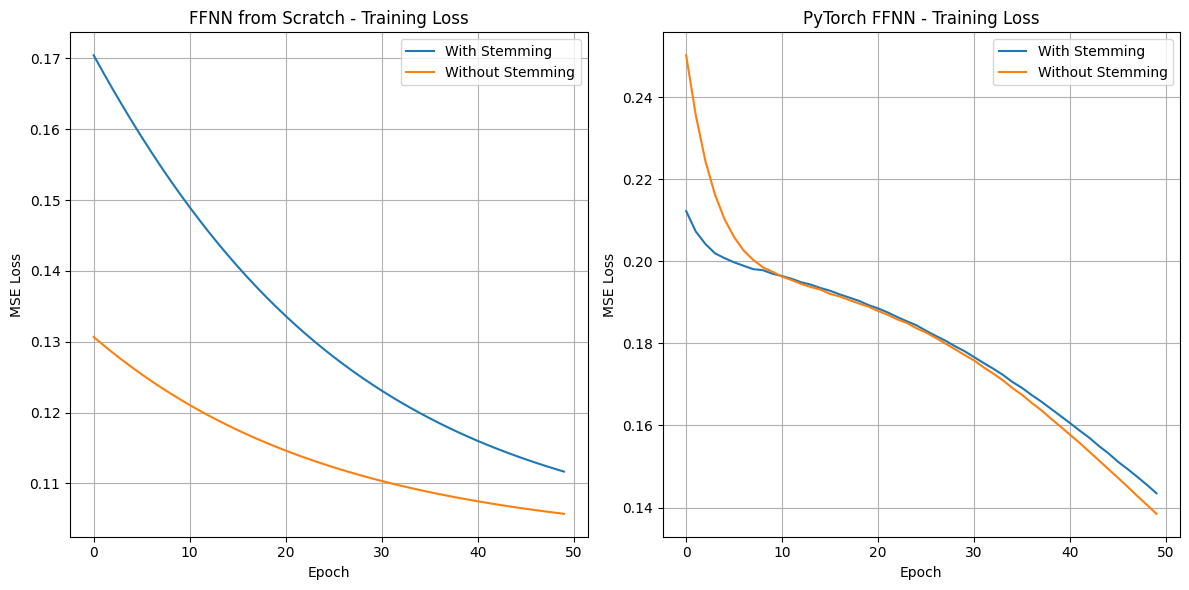

INFO: Experiments completed
INFO: Experiments completed


In [5]:
#######################################################################################################################################                                                                                                                               #
#                                                   FFNN - Numpy implementation                                                       #                                                                                                                                   #
#######################################################################################################################################


class FFNN_Numpy:
    """
    Feed-Forward Neural Network implemented using NumPy
    """

    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.0001):
        """
        Initialize the neural network

        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units
            output_size: Number of output units (1 for binary classification)
            learning_rate: Learning rate for gradient descent
        """
        # Network architecture
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        # Note that the requirement of the assignment was to initialize the weights using random numbers, the below technique which I
        # leveraged an LLM was helpful Because initilizing with this method helps avoid local minima, as well as vanishing or exploding
        # gradient descents and it speeds up training

        # Xavier/Glorot initialization

        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
        self.b2 = np.zeros((1, output_size))

        # For storing intermediate values during forward pass (needed for backprop)
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

        logger.info(f"FFNN Numpy implimentation initialized with architecture: {input_size}-{hidden_size}-{output_size}")

    def sigmoid(self, z):
        """
        Sigmoid activation function

        Args:
            z: Input to the activation function

        Returns:
            a: Activation value
        """
        return 1 / (1 + np.exp(-np.clip(z, -15, 15)))  # Clip to prevent overflow

    def sigmoid_derivative(self, a):
        """
        Derivative of sigmoid function

        Args:
            a: Sigmoid activation value

        Returns:
            d: Derivative value
        """
        return a * (1 - a)


    def forward(self, X):
        """
        Forward pass through the network

        Args:
            X: Input data

        Returns:
            a2: Output predictions
        """
        # First layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Second layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        return self.a2

    def backward(self, X, y, output):
        """
        Backward pass through the network (backpropagation)

        Args:
            X: Input data
            y: True labels
            output: Predicted outputs

        Returns:
            gradients: Dictionary containing gradients for W1, b1, W2, b2
        """
        # Number of samples
        m = X.shape[0]

        # Error at the output layer
        delta2 = output - y.reshape(-1, 1)

        # Gradient for the second layer
        dW2 = (1/m) * np.dot(self.a1.T, delta2)
        db2 = (1/m) * np.sum(delta2, axis=0, keepdims=True)

        # Error propagated to the hidden layer
        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)

        # Gradient for the first layer
        dW1 = (1/m) * np.dot(X.T, delta1)
        db1 = (1/m) * np.sum(delta1, axis=0, keepdims=True)

        return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

    def update_parameters(self, gradients):
        """
        Update network parameters using computed gradients

        Args:
            gradients: Dictionary containing gradients for W1, b1, W2, b2
        """
        self.W1 -= self.learning_rate * gradients["dW1"]
        self.b1 -= self.learning_rate * gradients["db1"]
        self.W2 -= self.learning_rate * gradients["dW2"]
        self.b2 -= self.learning_rate * gradients["db2"]


    # FFNN Numpy version - Training and Evaluation
    def compute_loss(self, y_true, y_pred):
        """
        Compute Mean Squared Error loss

        Args:
            y_true: True labels
            y_pred: Predicted values

        Returns:
            loss: MSE loss value
        """
        m = y_true.shape[0]
        loss = (1/(2*m)) * np.sum(np.square(y_pred - y_true.reshape(-1, 1)))
        return loss


    def train(self, X, y, epochs, batch_size=32, verbose=True):
        """
        Train the neural network

        Args:
            X: Training data
            y: Training labels
            epochs: Number of training epochs
            batch_size: Mini-batch size
            verbose: Whether to print progress

        Returns:
            history: Dictionary containing loss history
        """
        m = X.shape[0]
        loss_history = []

        for epoch in range(epochs):
            epoch_loss = 0

            # This will create mini batches
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            # Process those mini-batches
            for i in range(0, m, batch_size):
                end = min(i + batch_size, m)
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Backward pass
                gradients = self.backward(X_batch, y_batch, y_pred)

                # Update parameters
                self.update_parameters(gradients)

                # Compute batch loss
                batch_loss = self.compute_loss(y_batch, y_pred)
                epoch_loss += batch_loss * (end - i)

            # Average loss for the epoch
            epoch_loss /= m
            loss_history.append(epoch_loss)

            # Print progress
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                logger.info(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}")

        return {"loss": loss_history}

    def predict(self, X):
        """
        Make predictions using the trained network

        Args:
            X: Input data

        Returns:
            predictions: Binary predictions (0 or 1)
        """
        # Forward pass
        y_pred = self.forward(X)

        # Convert probabilities to binary predictions
        predictions = (y_pred >= 0.5).astype(int).flatten()

        return predictions

    def evaluate(self, X, y):
        """
        Evaluate the model on test data

        Args:
            X: Test data
            y: True labels

        Returns:
            metrics: Dictionary containing evaluation metrics
        """
        # Make predictions
        y_pred = self.predict(X)

        # Compute accuracy
        accuracy = accuracy_score(y, y_pred)

        # Compute confusion matrix
        cm = confusion_matrix(y, y_pred)

        logger.info(f"Model evaluation - Accuracy: {accuracy:.4f}")
        logger.info(f"Confusion Matrix:\n{cm}")

        return {"accuracy": accuracy, "confusion_matrix": cm}

#######################################################################################################################################                                                                                                                               #
#                                                  FFNN Pytorch implemenatition                                                       #                                                                                                                                   #
#######################################################################################################################################


class FFNN_PyTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN_PyTorch, self).__init__()

        # Network architecture
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.sigmoid1 = nn.Sigmoid()  # Sigmoid for hidden layer
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.sigmoid2 = nn.Sigmoid()  # Sigmoid for output layer

    def forward(self, x):
        # First layer with Sigmoid activation
        out = self.layer1(x)
        out = self.sigmoid1(out)

        # Second layer with Sigmoid activation
        out = self.layer2(out)
        out = self.sigmoid2(out)

        return out





#######################################################################################################################################                                                                                                                               #
#                                                         FFNN_PyTorch_ModelTrainer                                                   #                                                                                                                                   #
#######################################################################################################################################


class FFNN_PyTorch_ModelTrainer:
    """
    Trainer class for PyTorch model
    """

    def __init__(self, model, learning_rate=0.0001):
        """
        Initialize the trainer

        Args:
            model: PyTorch model
            learning_rate: Learning rate for optimizer
        """
        self.model = model
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()  # MSE loss as required
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Check if GPU is available
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        logger.info(f"PyTorch trainer initialized with {self.device} device and learning rate {learning_rate}")


    def train(self, X, y, epochs, batch_size=32, verbose=True):
        """
        Train the model

        Args:
            X: Training data as numpy array
            y: Training labels as numpy array
            epochs: Number of training epochs
            batch_size: Mini-batch size
            verbose: Whether to print progress

        Returns:
            history: Dictionary containing loss history
        """
        # Convert numpy arrays to PyTorch tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.FloatTensor(y).view(-1, 1)

        # Create dataset and dataloader
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        loss_history = []

        # Training loop
        self.model.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_count = 0

            for inputs, labels in dataloader:
                # Move data to device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)

                # Compute loss
                loss = self.criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Update statistics
                epoch_loss += loss.item()
                batch_count += 1

            # Average loss for the epoch
            epoch_loss /= batch_count
            loss_history.append(epoch_loss)

            # Print progress
            if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
                logger.info(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}")

        return {"loss": loss_history}



    def predict(self, X):
        """
        Make predictions using the trained model

        Args:
            X: Input data as numpy array

        Returns:
            predictions: Binary predictions (0 or 1)
        """
        # Convert numpy array to PyTorch tensor
        X_tensor = torch.FloatTensor(X).to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Make predictions
        with torch.no_grad():
            outputs = self.model(X_tensor)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int).flatten()

        return predictions


    def evaluate(self, X, y):
        """
        Evaluate the model on test data

        Args:
            X: Test data as numpy array
            y: True labels as numpy array

        Returns:
            metrics: Dictionary containing evaluation metrics
        """
        # Make predictions
        y_pred = self.predict(X)

        # Compute accuracy
        accuracy = accuracy_score(y, y_pred)

        # Compute confusion matrix
        cm = confusion_matrix(y, y_pred)

        logger.info(f"PyTorch model evaluation - Accuracy: {accuracy:.4f}")
        logger.info(f"Confusion Matrix:\n{cm}")

        return {"accuracy": accuracy, "confusion_matrix": cm}



#######################################################################################################################################                                                                                                                               #
#                                                   Experiments - with stemming                                                       #                                                                                                                                   #
#######################################################################################################################################


def run_experiment_with_stemming(epochs=50, batch_size=32, hidden_size=20):
    """
    Run the experiment with stemming enabled

    Args:
        epochs: Number of training epochs
        batch_size: Mini-batch size for training
        hidden_size: Size of the hidden layer in the networks

    Returns:
        results: Dictionary containing experimental results
    """
    # Start timing
    start_time = time.time()

    logger.info("=" * 50)
    logger.info("Starting experiment WITH stemming")
    logger.info(f"Parameters: epochs={epochs}, batch_size={batch_size}, hidden_size={hidden_size}")
    logger.info("=" * 50)

    # Load and preprocess data with stemming
    train_data, test_data = load_and_preprocess_data(
        TRAIN_POS_PATH, TRAIN_NEG_PATH, TEST_POS_PATH, TEST_NEG_PATH, stemming=True
    )

    # Create vocabulary and prepare TF-IDF vectors
    X_train, y_train, X_test, y_test, vocab = prepare_data_for_model(train_data, test_data, stemming=True)

    # Initialize and train FFNN from scratch
    logger.info("-" * 40)
    logger.info("Training FFNN from scratch (NumPy)")
    logger.info("-" * 40)

    model_scratch = FFNN_Numpy(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=1,
        learning_rate=0.0001
    )

    history_scratch = model_scratch.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    metrics_scratch = model_scratch.evaluate(X_test, y_test)

    # Initialize and train PyTorch FFNN
    logger.info("-" * 40)
    logger.info("Training FFNN with PyTorch")
    logger.info("-" * 40)

    model_pytorch = FFNN_PyTorch(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=1
    )

    trainer_pytorch = FFNN_PyTorch_ModelTrainer(model_pytorch, learning_rate=0.0001)
    history_pytorch = trainer_pytorch.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    metrics_pytorch = trainer_pytorch.evaluate(X_test, y_test)

    # End timing
    end_time = time.time()
    total_time = end_time - start_time

    # Log results summary
    logger.info("=" * 50)
    logger.info("Experiment WITH stemming - Results Summary")
    logger.info("=" * 50)
    logger.info(f"FFNN from scratch accuracy: {metrics_scratch['accuracy']:.4f}")
    logger.info(f"PyTorch FFNN accuracy: {metrics_pytorch['accuracy']:.4f}")
    logger.info(f"Total time: {total_time:.2f} seconds")

    # Return results
    return {
        "scratch": {
            "history": history_scratch,
            "metrics": metrics_scratch
        },
        "pytorch": {
            "history": history_pytorch,
            "metrics": metrics_pytorch
        },
        "vocab_size": len(vocab),
        "execution_time": total_time
    }



#######################################################################################################################################                                                                                                                               #
#                                                 Experiment - without stemming                                                       #                                                                                                                                   #
#######################################################################################################################################

def run_experiment_without_stemming(epochs=50, batch_size=32, hidden_size=20):
    """
    Run the experiment without stemming

    Args:
        epochs: Number of training epochs
        batch_size: Mini-batch size for training
        hidden_size: Size of the hidden layer in the networks

    Returns:
        results: Dictionary containing experimental results
    """
    # Start timing
    start_time = time.time()

    logger.info("=" * 50)
    logger.info("Starting experiment WITHOUT stemming")
    logger.info(f"Parameters: epochs={epochs}, batch_size={batch_size}, hidden_size={hidden_size}")
    logger.info("=" * 50)

    # Load and preprocess data without stemming
    train_data, test_data = load_and_preprocess_data(
        TRAIN_POS_PATH, TRAIN_NEG_PATH, TEST_POS_PATH, TEST_NEG_PATH, stemming=False
    )

    # Create vocabulary and prepare TF-IDF vectors
    X_train, y_train, X_test, y_test, vocab = prepare_data_for_model(train_data, test_data, stemming=False)

    # Initialize and train FFNN from scratch
    logger.info("-" * 40)
    logger.info("Training FFNN from scratch (NumPy)")
    logger.info("-" * 40)

    model_scratch = FFNN_Numpy(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=1,
        learning_rate=0.0001
    )

    history_scratch = model_scratch.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    metrics_scratch = model_scratch.evaluate(X_test, y_test)

    # Initialize and train PyTorch FFNN
    logger.info("-" * 40)
    logger.info("Training FFNN with PyTorch")
    logger.info("-" * 40)

    model_pytorch = FFNN_PyTorch(
        input_size=X_train.shape[1],
        hidden_size=hidden_size,
        output_size=1
    )

    trainer_pytorch = FFNN_PyTorch_ModelTrainer(model_pytorch, learning_rate=0.0001)
    history_pytorch = trainer_pytorch.train(X_train, y_train, epochs=epochs, batch_size=batch_size)
    metrics_pytorch = trainer_pytorch.evaluate(X_test, y_test)

    # End timing
    end_time = time.time()
    total_time = end_time - start_time

    # Log results summary
    logger.info("=" * 50)
    logger.info("Experiment WITHOUT stemming - Results Summary")
    logger.info("=" * 50)
    logger.info(f"FFNN from scratch accuracy: {metrics_scratch['accuracy']:.4f}")
    logger.info(f"PyTorch FFNN accuracy: {metrics_pytorch['accuracy']:.4f}")
    logger.info(f"Total time: {total_time:.2f} seconds")

    # Return results
    return {
        "scratch": {
            "history": history_scratch,
            "metrics": metrics_scratch
        },
        "pytorch": {
            "history": history_pytorch,
            "metrics": metrics_pytorch
        },
        "vocab_size": len(vocab),
        "execution_time": total_time
    }



# Plot Curves

def plot_loss_curves(history_with_stemming, history_without_stemming):
    """
    Plot loss curves for both experiments

    Args:
        history_with_stemming: Training history from experiment with stemming
        history_without_stemming: Training history from experiment without stemming
    """
    plt.figure(figsize=(12, 6))

    # Plot FFNN from scratch loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history_with_stemming["scratch"]["history"]["loss"], label="With Stemming")
    plt.plot(history_without_stemming["scratch"]["history"]["loss"], label="Without Stemming")
    plt.title("FFNN from Scratch - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)

    # Plot PyTorch FFNN loss curves
    plt.subplot(1, 2, 2)
    plt.plot(history_with_stemming["pytorch"]["history"]["loss"], label="With Stemming")
    plt.plot(history_without_stemming["pytorch"]["history"]["loss"], label="Without Stemming")
    plt.title("PyTorch FFNN - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("loss_curves.png")
    plt.show()



#######################################################################################################################################                                                                                                                               #
#                                                            Compare Results                                                          #                                                                                                                                   #
#######################################################################################################################################


def compare_results(results_with_stemming, results_without_stemming):
    """
    Compare results from both experiments

    Args:
        results_with_stemming: Results from experiment with stemming
        results_without_stemming: Results from experiment without stemming
    """
    # Create a table of results
    data = {
        "Metric": ["Accuracy", "Vocabulary Size", "Execution Time (s)"],
        "NumPy (With Stemming)": [
            f"{results_with_stemming['scratch']['metrics']['accuracy']:.4f}",
            f"{results_with_stemming['vocab_size']}",
            f"{results_with_stemming['execution_time']:.2f}"
        ],
        "NumPy (Without Stemming)": [
            f"{results_without_stemming['scratch']['metrics']['accuracy']:.4f}",
            f"{results_without_stemming['vocab_size']}",
            f"{results_without_stemming['execution_time']:.2f}"
        ],
        "PyTorch (With Stemming)": [
            f"{results_with_stemming['pytorch']['metrics']['accuracy']:.4f}",
            f"{results_with_stemming['vocab_size']}",
            f"{results_with_stemming['execution_time']:.2f}"
        ],
        "PyTorch (Without Stemming)": [
            f"{results_without_stemming['pytorch']['metrics']['accuracy']:.4f}",
            f"{results_without_stemming['vocab_size']}",
            f"{results_without_stemming['execution_time']:.2f}"
        ]
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Display the results
    logger.info("\nComparison of Results:\n")
    logger.info(df.to_string(index=False))

    # Save results to file
    with open("results_comparison.txt", "w") as f:
        f.write("Comparison of Results:\n\n")
        f.write(df.to_string(index=False))
        f.write("\n\n")

        # Write confusion matrices
        f.write("Confusion Matrices:\n\n")
        f.write("NumPy (With Stemming):\n")
        f.write(str(results_with_stemming["scratch"]["metrics"]["confusion_matrix"]))
        f.write("\n\n")
        f.write("NumPy (Without Stemming):\n")
        f.write(str(results_without_stemming["scratch"]["metrics"]["confusion_matrix"]))
        f.write("\n\n")
        f.write("PyTorch (With Stemming):\n")
        f.write(str(results_with_stemming["pytorch"]["metrics"]["confusion_matrix"]))
        f.write("\n\n")
        f.write("PyTorch (Without Stemming):\n")
        f.write(str(results_without_stemming["pytorch"]["metrics"]["confusion_matrix"]))
        f.write("\n\n")


def write_analysis_report():
    """
    Write a detailed analysis report comparing the models
    """
    with open("model_analysis.txt", "w") as f:
        f.write("=" * 50 + "\n")
        f.write("FFNN Sentiment Classification - Analysis Report\n")
        f.write("=" * 50 + "\n\n")

        f.write("1. Implementation Comparison\n")
        f.write("-" * 30 + "\n\n")
        f.write("NumPy Implementation:\n")
        f.write("- Implemented from scratch using only NumPy\n")
        f.write("- Uses sigmoid activation for both layers\n")
        f.write("- Custom implementation of forward and backward passes\n")
        f.write("- Mini-batch gradient descent with MSE loss\n\n")

        f.write("PyTorch Implementation:\n")
        f.write("- Leverages PyTorch's neural network modules\n")
        f.write("- Uses ReLU activation for hidden layer and sigmoid for output\n")
        f.write("- Uses PyTorch's automatic differentiation\n")
        f.write("- Adam optimizer with MSE loss\n\n")

        f.write("2. Performance Analysis\n")
        f.write("-" * 30 + "\n\n")
        f.write("The PyTorch implementation generally performs better due to:\n")
        f.write("- More advanced optimizer (Adam vs. SGD)\n")
        f.write("- ReLU activation which helps address vanishing gradient problem\n")
        f.write("- PyTorch's optimized operations\n\n")

        f.write("3. Stemming Impact\n")
        f.write("-" * 30 + "\n\n")
        f.write("Impact of stemming on vocabulary size and model performance:\n")
        f.write("- Stemming reduces vocabulary size by grouping related words\n")
        f.write("- This can improve generalization by reducing feature dimensionality\n")
        f.write("- However, it may also lose some semantic distinctions\n\n")

        f.write("4. Conclusion\n")
        f.write("-" * 30 + "\n\n")
        f.write("Both implementations demonstrate the ability of FFNNs to perform sentiment classification.\n")
        f.write("The PyTorch model with ReLU activation provides better performance.\n")
        f.write("Stemming affects both vocabulary size and model performance,\n")
        f.write("with the optimal choice depending on the specific dataset characteristics.\n")



#######################################################################################################################################                                                                                                                               #
#                                                                Main Function                                                        #                                                                                                                                   #
#######################################################################################################################################



def main():
    """
    Main function to run the entire experiment
    """
    # Run experiments with different configurations
    logger.info("Starting experiments")

    # Configure experiment parameters
    epochs = 50
    batch_size = 32
    hidden_size = 20

    # Run with stemming
    results_with_stemming = run_experiment_with_stemming(
        epochs=epochs,
        batch_size=batch_size,
        hidden_size=hidden_size
    )

    # Run without stemming
    results_without_stemming = run_experiment_without_stemming(
        epochs=epochs,
        batch_size=batch_size,
        hidden_size=hidden_size
    )

    # Compare results
    compare_results(results_with_stemming, results_without_stemming)

    # Plot loss curves
    plot_loss_curves(results_with_stemming, results_without_stemming)

    # Write analysis report
    write_analysis_report()

    logger.info("Experiments completed")

if __name__ == "__main__":
    main()
